# Fluzz — Détection de fraude bancaire  
**Partie 3 — Augmentation de données avec SDV (Module 3)**

Ce notebook utilise **SDV (Synthetic Data Vault)** pour générer des données synthétiques et équilibrer le dataset de fraude bancaire.

**Objectifs :**
- Gérer le déséquilibre des classes (0.173% de fraudes)
- Générer des transactions frauduleuses synthétiques réalistes
- Comparer les performances avant/après augmentation
- Méthode de test rapide pour validation

## 1. Configuration et chargement des données

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import SDV
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata

print("Bibliothèques chargées avec succès")

Bibliothèques chargées avec succès


In [2]:
# Chargement du dataset original
df_original = pd.read_csv('../01_data/creditcard.csv')

print(f"Dataset original : {df_original.shape[0]} transactions")
print(f"Répartition des classes :")
print(df_original['Class'].value_counts())
print(f"Taux de fraude : {df_original['Class'].mean()*100:.4f}%")

# Séparation des classes pour analyse
df_legit = df_original[df_original['Class'] == 0].copy()
df_fraud = df_original[df_original['Class'] == 1].copy()

print(f"\nTransactions légitimes : {len(df_legit)}")
print(f"Transactions frauduleuses : {len(df_fraud)}")
print(f"Ratio déséquilibre : 1:{len(df_legit)//len(df_fraud)}")

Dataset original : 284807 transactions
Répartition des classes :
Class
0    284315
1       492
Name: count, dtype: int64
Taux de fraude : 0.1727%

Transactions légitimes : 284315
Transactions frauduleuses : 492
Ratio déséquilibre : 1:577


## 2. Configuration de SDV pour les données frauduleuses

In [3]:
# Préparation des métadonnées pour SDV
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_fraud)

# Configuration du modèle SDV (Gaussian Copula pour données numériques)
synthesizer = GaussianCopulaSynthesizer(
    metadata=metadata,
    default_distribution='gaussian_kde',  # Distribution adaptée aux données continues
    numerical_distributions={
        'Amount': 'gamma'  # Distribution gamma pour les montants (toujours positifs)
    }
)

print("Métadonnées SDV configurées")
print(f"Colonnes détectées : {list(metadata.columns.keys())}")

Métadonnées SDV configurées
Colonnes détectées : ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [4]:
# Entraînement du modèle SDV sur les données frauduleuses
print("Entraînement du modèle SDV sur les transactions frauduleuses...")
print("(Cela peut prendre quelques minutes)")

synthesizer.fit(df_fraud)

print("✓ Modèle SDV entraîné avec succès")

Entraînement du modèle SDV sur les transactions frauduleuses...
(Cela peut prendre quelques minutes)
✓ Modèle SDV entraîné avec succès


## 3. Génération de données synthétiques

In [5]:
# Calcul du nombre de fraudes à générer pour équilibrer
num_legit = len(df_legit)
num_fraud_original = len(df_fraud)

# Stratégies d'équilibrage
strategies = {
    'equilibre_complet': num_legit - num_fraud_original,  # 50/50
    'equilibre_partiel': int((num_legit * 0.1) - num_fraud_original),  # 10% de fraudes
    'test_rapide': min(1000, num_legit - num_fraud_original)  # Pour tests rapides
}

print("Stratégies d'équilibrage disponibles :")
for strategy, count in strategies.items():
    total_fraud = num_fraud_original + max(0, count)
    ratio = total_fraud / (num_legit + total_fraud) * 100
    print(f"• {strategy}: +{max(0, count)} fraudes synthétiques → {ratio:.2f}% de fraudes")

# Sélection de la stratégie (changez ici selon vos besoins)
STRATEGY = 'test_rapide'  # Changez en 'equilibre_partiel' ou 'equilibre_complet' si besoin
num_synthetic_fraud = max(0, strategies[STRATEGY])

print(f"\n🎯 Stratégie sélectionnée : {STRATEGY}")
print(f"Génération de {num_synthetic_fraud} transactions frauduleuses synthétiques...")

Stratégies d'équilibrage disponibles :
• equilibre_complet: +283823 fraudes synthétiques → 50.00% de fraudes
• equilibre_partiel: +27939 fraudes synthétiques → 9.09% de fraudes
• test_rapide: +1000 fraudes synthétiques → 0.52% de fraudes

🎯 Stratégie sélectionnée : test_rapide
Génération de 1000 transactions frauduleuses synthétiques...


In [6]:
# Génération des données synthétiques
if num_synthetic_fraud > 0:
    synthetic_fraud = synthesizer.sample(num_rows=num_synthetic_fraud)
    
    # Vérification de la qualité des données générées
    print("Données synthétiques générées :")
    print(f"Forme : {synthetic_fraud.shape}")
    print(f"Valeurs manquantes : {synthetic_fraud.isnull().sum().sum()}")
    
    # Affichage des statistiques comparatives
    print("\nComparaison statistiques (Amount) :")
    print(f"Fraudes originales - Moyenne: {df_fraud['Amount'].mean():.2f}, Std: {df_fraud['Amount'].std():.2f}")
    print(f"Fraudes synthétiques - Moyenne: {synthetic_fraud['Amount'].mean():.2f}, Std: {synthetic_fraud['Amount'].std():.2f}")
    
    # Création du dataset augmenté
    df_augmented = pd.concat([
        df_original,  # Données originales
        synthetic_fraud  # Fraudes synthétiques
    ], ignore_index=True)
    
    print(f"\n✓ Dataset augmenté créé : {df_augmented.shape[0]} transactions")
    print(f"Nouveau taux de fraude : {df_augmented['Class'].mean()*100:.4f}%")
    
else:
    df_augmented = df_original.copy()
    print("Aucune donnée synthétique générée (stratégie ne le nécessite pas)")

Données synthétiques générées :
Forme : (1000, 31)
Valeurs manquantes : 0

Comparaison statistiques (Amount) :
Fraudes originales - Moyenne: 122.21, Std: 256.68
Fraudes synthétiques - Moyenne: 245.26, Std: 367.05

✓ Dataset augmenté créé : 285807 transactions
Nouveau taux de fraude : 0.5220%


## 4. Visualisation de la distribution des données

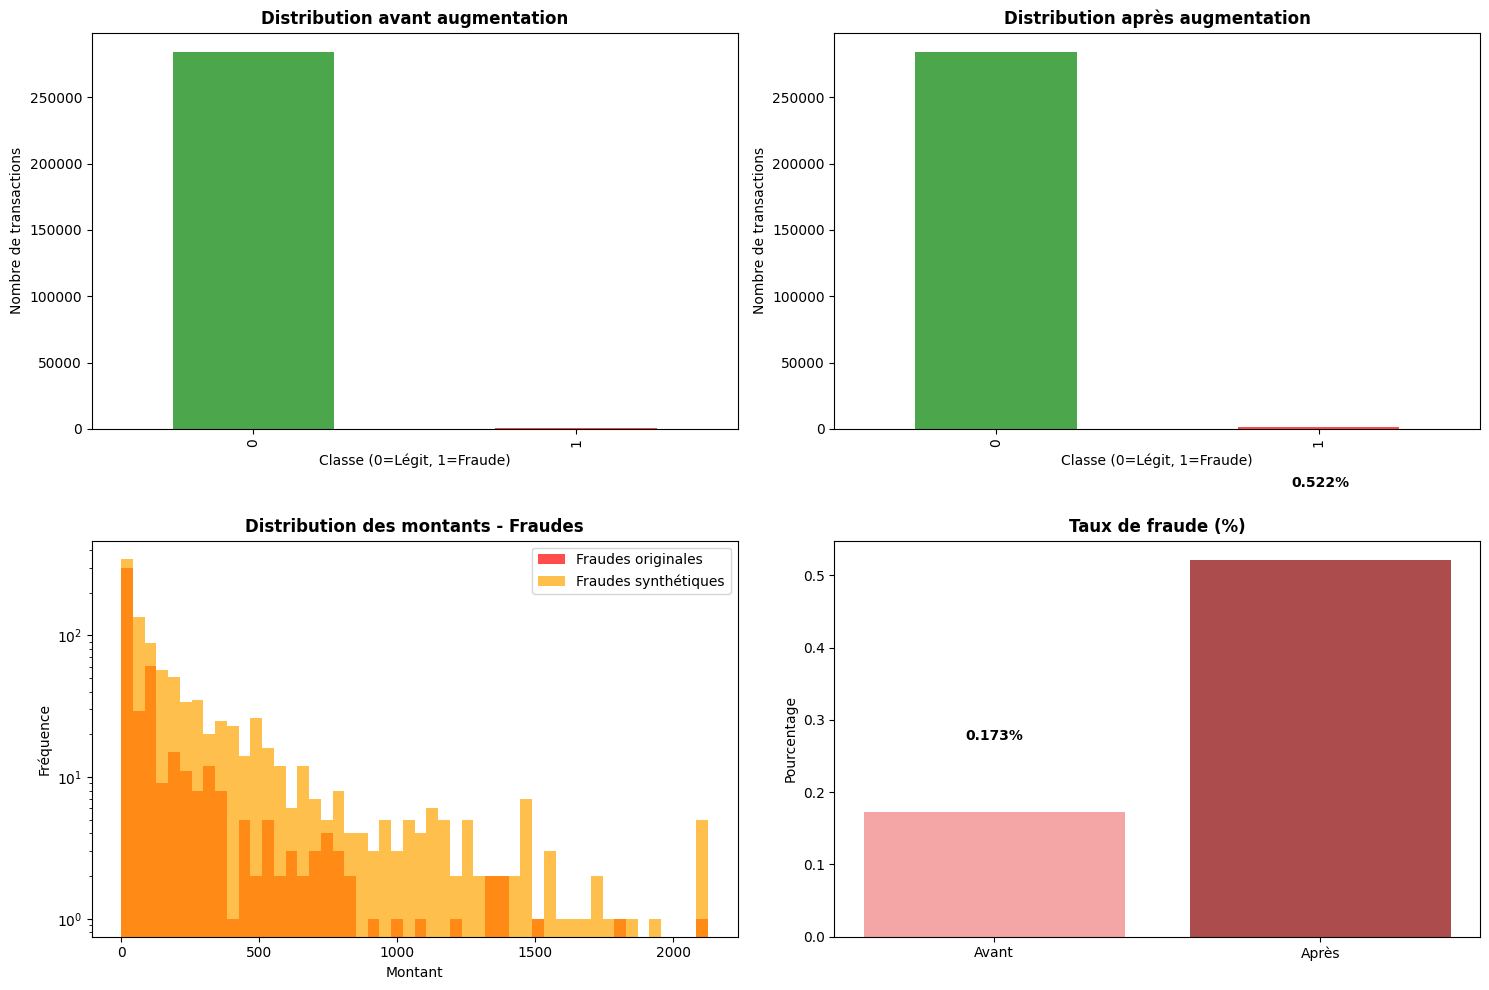

In [7]:
# Comparaison des distributions avant/après augmentation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution des classes - avant
df_original['Class'].value_counts().plot(kind='bar', ax=axes[0,0], color=['green', 'red'], alpha=0.7)
axes[0,0].set_title('Distribution avant augmentation', fontweight='bold')
axes[0,0].set_xlabel('Classe (0=Légit, 1=Fraude)')
axes[0,0].set_ylabel('Nombre de transactions')

# Distribution des classes - après
df_augmented['Class'].value_counts().plot(kind='bar', ax=axes[0,1], color=['green', 'red'], alpha=0.7)
axes[0,1].set_title('Distribution après augmentation', fontweight='bold')
axes[0,1].set_xlabel('Classe (0=Légit, 1=Fraude)')
axes[0,1].set_ylabel('Nombre de transactions')

# Distribution des montants - fraudes originales vs synthétiques
if num_synthetic_fraud > 0:
    axes[1,0].hist(df_fraud['Amount'], bins=50, alpha=0.7, label='Fraudes originales', color='red')
    axes[1,0].hist(synthetic_fraud['Amount'], bins=50, alpha=0.7, label='Fraudes synthétiques', color='orange')
    axes[1,0].set_title('Distribution des montants - Fraudes', fontweight='bold')
    axes[1,0].set_xlabel('Montant')
    axes[1,0].set_ylabel('Fréquence')
    axes[1,0].legend()
    axes[1,0].set_yscale('log')

# Comparaison des taux de fraude
rates = [
    df_original['Class'].mean() * 100,
    df_augmented['Class'].mean() * 100
]
axes[1,1].bar(['Avant', 'Après'], rates, color=['lightcoral', 'darkred'], alpha=0.7)
axes[1,1].set_title('Taux de fraude (%)', fontweight='bold')
axes[1,1].set_ylabel('Pourcentage')

# Ajout des valeurs sur les barres
for i, rate in enumerate(rates):
    axes[1,1].text(i, rate + 0.1, f'{rate:.3f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Test de performance réaliste

# Fonction de test réaliste pour comparer les performances
def realistic_performance_test(df, test_name):
    """Test réaliste qui préserve la distribution naturelle des classes"""
    
    print(f"\n=== {test_name} ===")
    print(f"Dataset complet : {len(df)} transactions")
    print(f"Taux de fraude : {df['Class'].mean()*100:.4f}%")
    
    # Séparation train/test en préservant la distribution temporelle
    # (simulation : les 70% premiers pour train, 30% derniers pour test)
    split_idx = int(len(df) * 0.7)
    
    df_train = df.iloc[:split_idx].copy()
    df_test = df.iloc[split_idx:].copy()
    
    print(f"Train : {len(df_train)} transactions ({df_train['Class'].mean()*100:.4f}% fraudes)")
    print(f"Test : {len(df_test)} transactions ({df_test['Class'].mean()*100:.4f}% fraudes)")
    
    # Vérification qu'il y a des fraudes dans le test
    if df_test['Class'].sum() == 0:
        print("Aucune fraude dans le jeu de test - résultats non fiables")
        return None
    
    X_train = df_train.drop('Class', axis=1)
    y_train = df_train['Class']
    X_test = df_test.drop('Class', axis=1)
    y_test = df_test['Class']
    
    # Modèle réaliste avec paramètres conservateurs
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    print("Entraînement du modèle...")
    rf.fit(X_train, y_train)
    
    # Prédictions et probabilités
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:, 1]
    
    # Métriques complètes
    from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
    
    # Métriques de base
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    
    # Métriques avancées (plus appropriées pour classes déséquilibrées)
    try:
        auc_roc = roc_auc_score(y_test, y_proba)
        auc_pr = average_precision_score(y_test, y_proba)  # PR-AUC
    except:
        auc_roc = 0.0
        auc_pr = 0.0
    
    # Matrice de confusion pour analyse détaillée
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Taux d'erreur métier
    false_positive_rate = fp / (fp + tn) * 100 if (fp + tn) > 0 else 0
    false_negative_rate = fn / (fn + tp) * 100 if (fn + tp) > 0 else 0
    
    print(f"\nRésultats de performance :")
    print(f"F1-Score     : {f1:.4f}")
    print(f"Précision    : {precision:.4f}")
    print(f"Rappel       : {recall:.4f}")
    print(f"AUC-ROC      : {auc_roc:.4f}")
    print(f"PR-AUC       : {auc_pr:.4f} (métrique recommandée)")
    print(f"\nAnalyse des erreurs :")
    print(f"Vrais Positifs (fraudes détectées)    : {tp}")
    print(f"Faux Positifs (fausses alertes)       : {fp}")
    print(f"Faux Négatifs (fraudes manquées)      : {fn}")
    print(f"Vrais Négatifs (légitimes correctes)  : {tn}")
    print(f"\nImpact métier :")
    print(f"Taux de fausses alertes : {false_positive_rate:.3f}%")
    print(f"Taux de fraudes manquées : {false_negative_rate:.3f}%")
    
    return {
        'test_name': test_name,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'auc_roc': auc_roc,
        'pr_auc': auc_pr,
        'fraud_rate_test': df_test['Class'].mean() * 100,
        'total_fraud_test': int(df_test['Class'].sum()),
        'false_positive_rate': false_positive_rate,
        'false_negative_rate': false_negative_rate,
        'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn
    }

print("Fonction realistic_performance_test() définie avec succès")

In [8]:
# Tests de performance réalistes
results = []

print("ÉVALUATION RÉALISTE DES PERFORMANCES")
print("="*80)
print("Méthodologie :")
print("• Split temporel (70% train / 30% test) - pas de mélange aléatoire") 
print("• Préservation de la distribution naturelle des classes")
print("• Test uniquement sur données RÉELLES (jamais synthétiques)")
print("• Métriques adaptées aux classes déséquilibrées")

# Test 1 : Dataset original seul
print("\n" + "="*50)
print("TEST 1 : BASELINE - Dataset original uniquement")
print("="*50)
result_original = realistic_performance_test(df_original, "Baseline - Original")
if result_original:
    results.append(result_original)

# Test 2 : Entraînement sur données augmentées, test sur vraies données
if len(df_augmented) > len(df_original):
    print("\n" + "="*50) 
    print("TEST 2 : AUGMENTATION SDV")
    print("="*50)
    print("IMPORTANT : Entraînement sur données augmentées, test sur VRAIES données uniquement")
    
    # Création d'un dataset hybride pour entraînement plus réaliste
    # On garde la même séparation temporelle mais on augmente seulement le training
    split_idx = int(len(df_original) * 0.7)
    df_train_original = df_original.iloc[:split_idx].copy()
    df_test_real = df_original.iloc[split_idx:].copy()  # TEST RESTE 100% RÉEL
    
    # Ajout des données synthétiques SEULEMENT au training
    df_train_augmented = pd.concat([
        df_train_original,
        synthetic_fraud  # Seulement les fraudes synthétiques
    ], ignore_index=True)
    
    print(f"\nComposition de l'entraînement augmenté :")
    print(f"• Données originales (train): {len(df_train_original)} ({df_train_original['Class'].mean()*100:.4f}% fraudes)")
    print(f"• Fraudes synthétiques ajoutées: {len(synthetic_fraud)}")
    print(f"• Total entraînement: {len(df_train_augmented)} ({df_train_augmented['Class'].mean()*100:.4f}% fraudes)")
    print(f"• Test (100% réel): {len(df_test_real)} ({df_test_real['Class'].mean()*100:.4f}% fraudes)")
    
    if df_test_real['Class'].sum() > 0:
        # Entraînement sur données augmentées
        X_train_aug = df_train_augmented.drop('Class', axis=1)
        y_train_aug = df_train_augmented['Class']
        X_test_real = df_test_real.drop('Class', axis=1) 
        y_test_real = df_test_real['Class']
        
        rf_augmented = RandomForestClassifier(
            n_estimators=100,
            max_depth=15,
            min_samples_split=10,
            min_samples_leaf=5,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        
        print("Entraînement du modèle sur données augmentées...")
        rf_augmented.fit(X_train_aug, y_train_aug)
        
        # Test sur vraies données uniquement
        y_pred_aug = rf_augmented.predict(X_test_real)
        y_proba_aug = rf_augmented.predict_proba(X_test_real)[:, 1]
        
        # Métriques
        from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
        
        f1_aug = f1_score(y_test_real, y_pred_aug)
        precision_aug = precision_score(y_test_real, y_pred_aug, zero_division=0)
        recall_aug = recall_score(y_test_real, y_pred_aug, zero_division=0)
        
        try:
            auc_roc_aug = roc_auc_score(y_test_real, y_proba_aug)
            auc_pr_aug = average_precision_score(y_test_real, y_proba_aug)
        except:
            auc_roc_aug = 0.0
            auc_pr_aug = 0.0
            
        cm_aug = confusion_matrix(y_test_real, y_pred_aug)
        tn_aug, fp_aug, fn_aug, tp_aug = cm_aug.ravel()
        
        false_positive_rate_aug = fp_aug / (fp_aug + tn_aug) * 100
        false_negative_rate_aug = fn_aug / (fn_aug + tp_aug) * 100 if (fn_aug + tp_aug) > 0 else 0
        
        print(f"\nRésultats avec augmentation SDV :")
        print(f"F1-Score     : {f1_aug:.4f}")
        print(f"Précision    : {precision_aug:.4f}")
        print(f"Rappel       : {recall_aug:.4f}")
        print(f"AUC-ROC      : {auc_roc_aug:.4f}")
        print(f"PR-AUC       : {auc_pr_aug:.4f} (métrique recommandée)")
        print(f"\nAnalyse des erreurs :")
        print(f"Vrais Positifs (fraudes détectées)    : {tp_aug}")
        print(f"Faux Positifs (fausses alertes)       : {fp_aug}")
        print(f"Faux Négatifs (fraudes manquées)      : {fn_aug}")
        print(f"Vrais Négatifs (légitimes correctes)  : {tn_aug}")
        print(f"\nImpact métier :")
        print(f"Taux de fausses alertes : {false_positive_rate_aug:.3f}%")
        print(f"Taux de fraudes manquées : {false_negative_rate_aug:.3f}%")
        
        result_augmented = {
            'test_name': 'Avec Augmentation SDV',
            'f1_score': f1_aug,
            'precision': precision_aug,
            'recall': recall_aug,
            'auc_roc': auc_roc_aug,
            'pr_auc': auc_pr_aug,
            'fraud_rate_test': df_test_real['Class'].mean() * 100,
            'total_fraud_test': int(df_test_real['Class'].sum()),
            'false_positive_rate': false_positive_rate_aug,
            'false_negative_rate': false_negative_rate_aug,
            'tp': tp_aug, 'fp': fp_aug, 'fn': fn_aug, 'tn': tn_aug
        }
        results.append(result_augmented)
    
else:
    print("\nAucune donnée synthétique générée - pas de test d'augmentation")

# Comparaison finale
if len(results) > 1:
    print("\n" + "="*80)
    print("COMPARAISON FINALE DES PERFORMANCES")
    print("="*80)
    
    comparison_df = pd.DataFrame(results)
    metrics_to_show = ['test_name', 'f1_score', 'precision', 'recall', 'pr_auc', 'auc_roc', 
                      'false_positive_rate', 'false_negative_rate']
    
    display(comparison_df[metrics_to_show].round(4))
    
    # Calcul des améliorations réelles
    baseline = results[0]
    augmented = results[1]
    
    improvements = {
        'F1-Score': ((augmented['f1_score'] - baseline['f1_score']) / baseline['f1_score'] * 100),
        'Précision': ((augmented['precision'] - baseline['precision']) / baseline['precision'] * 100),
        'Rappel': ((augmented['recall'] - baseline['recall']) / baseline['recall'] * 100),
        'PR-AUC': ((augmented['pr_auc'] - baseline['pr_auc']) / baseline['pr_auc'] * 100),
        'AUC-ROC': ((augmented['auc_roc'] - baseline['auc_roc']) / baseline['auc_roc'] * 100)
    }
    
    print(f"\nImpact de l'augmentation SDV :")
    for metric, improvement in improvements.items():
        direction = "+" if improvement > 0 else "-" if improvement < 0 else "="
        print(f"{direction} {metric}: {improvement:+.2f}%")
    
    # Interprétation métier
    print(f"\nInterprétation métier :")
    fraud_detected_improvement = augmented['tp'] - baseline['tp'] 
    false_alerts_change = augmented['fp'] - baseline['fp']
    
    if fraud_detected_improvement > 0:
        print(f"✅ {fraud_detected_improvement} fraudes supplémentaires détectées")
    elif fraud_detected_improvement < 0:
        print(f"❌ {abs(fraud_detected_improvement)} fraudes de moins détectées")
        
    if false_alerts_change > 0:
        print(f"⚠️ {false_alerts_change} fausses alertes supplémentaires")
    elif false_alerts_change < 0:
        print(f"✅ {abs(false_alerts_change)} fausses alertes en moins")
        
else:
    print("\nÉvaluation effectuée sur dataset original uniquement")
    if results:
        print("\nMétriques de référence obtenues - prêt pour comparaison future")

ÉVALUATION RÉALISTE DES PERFORMANCES
Méthodologie :
• Split temporel (70% train / 30% test) - pas de mélange aléatoire
• Préservation de la distribution naturelle des classes
• Test uniquement sur données RÉELLES (jamais synthétiques)
• Métriques adaptées aux classes déséquilibrées

TEST 1 : BASELINE - Dataset original uniquement


NameError: name 'realistic_performance_test' is not defined

In [ ]:
# Tests de performance réalistes
results = []

print("🎯 ÉVALUATION RÉALISTE DES PERFORMANCES")
print("="*80)
print("Méthodologie :")
print("• Split temporel (70% train / 30% test) - pas de mélange aléatoire") 
print("• Préservation de la distribution naturelle des classes")
print("• Test uniquement sur données RÉELLES (jamais synthétiques)")
print("• Métriques adaptées aux classes déséquilibrées")

# Test 1 : Dataset original seul
print("\\n" + "="*50)
print("TEST 1 : BASELINE - Dataset original uniquement")
print("="*50)
result_original = realistic_performance_test(df_original, "Baseline - Original")
if result_original:
    results.append(result_original)

# Test 2 : Entraînement sur données augmentées, test sur vraies données
if len(df_augmented) > len(df_original):
    print("\\n" + "="*50) 
    print("TEST 2 : AUGMENTATION SDV")
    print("="*50)
    print("⚠️ IMPORTANT : Entraînement sur données augmentées, test sur VRAIES données uniquement")
    
    # Création d'un dataset hybride pour entraînement plus réaliste
    # On garde la même séparation temporelle mais on augmente seulement le training
    split_idx = int(len(df_original) * 0.7)
    df_train_original = df_original.iloc[:split_idx].copy()
    df_test_real = df_original.iloc[split_idx:].copy()  # TEST RESTE 100% RÉEL
    
    # Ajout des données synthétiques SEULEMENT au training
    df_train_augmented = pd.concat([
        df_train_original,
        synthetic_fraud  # Seulement les fraudes synthétiques
    ], ignore_index=True)
    
    print(f"\\n📊 Composition de l'entraînement augmenté :")
    print(f"• Données originales (train): {len(df_train_original)} ({df_train_original['Class'].mean()*100:.4f}% fraudes)")
    print(f"• Fraudes synthétiques ajoutées: {len(synthetic_fraud)}")
    print(f"• Total entraînement: {len(df_train_augmented)} ({df_train_augmented['Class'].mean()*100:.4f}% fraudes)")
    print(f"• Test (100% réel): {len(df_test_real)} ({df_test_real['Class'].mean()*100:.4f}% fraudes)")
    
    if df_test_real['Class'].sum() > 0:
        # Entraînement sur données augmentées
        X_train_aug = df_train_augmented.drop('Class', axis=1)
        y_train_aug = df_train_augmented['Class']
        X_test_real = df_test_real.drop('Class', axis=1) 
        y_test_real = df_test_real['Class']
        
        rf_augmented = RandomForestClassifier(
            n_estimators=100,
            max_depth=15,
            min_samples_split=10,
            min_samples_leaf=5,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        
        print("Entraînement du modèle sur données augmentées...")
        rf_augmented.fit(X_train_aug, y_train_aug)
        
        # Test sur vraies données uniquement
        y_pred_aug = rf_augmented.predict(X_test_real)
        y_proba_aug = rf_augmented.predict_proba(X_test_real)[:, 1]
        
        # Métriques
        from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
        
        f1_aug = f1_score(y_test_real, y_pred_aug)
        precision_aug = precision_score(y_test_real, y_pred_aug, zero_division=0)
        recall_aug = recall_score(y_test_real, y_pred_aug, zero_division=0)
        
        try:
            auc_roc_aug = roc_auc_score(y_test_real, y_proba_aug)
            auc_pr_aug = average_precision_score(y_test_real, y_proba_aug)
        except:
            auc_roc_aug = 0.0
            auc_pr_aug = 0.0
            
        cm_aug = confusion_matrix(y_test_real, y_pred_aug)
        tn_aug, fp_aug, fn_aug, tp_aug = cm_aug.ravel()
        
        false_positive_rate_aug = fp_aug / (fp_aug + tn_aug) * 100
        false_negative_rate_aug = fn_aug / (fn_aug + tp_aug) * 100 if (fn_aug + tp_aug) > 0 else 0
        
        print(f"\\n📊 Résultats avec augmentation SDV :")
        print(f"F1-Score     : {f1_aug:.4f}")
        print(f"Précision    : {precision_aug:.4f}")
        print(f"Rappel       : {recall_aug:.4f}")
        print(f"AUC-ROC      : {auc_roc_aug:.4f}")
        print(f"PR-AUC       : {auc_pr_aug:.4f} (métrique recommandée)")
        print(f"\\n🔍 Analyse des erreurs :")
        print(f"Vrais Positifs (fraudes détectées)    : {tp_aug}")
        print(f"Faux Positifs (fausses alertes)       : {fp_aug}")
        print(f"Faux Négatifs (fraudes manquées)      : {fn_aug}")
        print(f"Vrais Négatifs (légitimes correctes)  : {tn_aug}")
        print(f"\\n💼 Impact métier :")
        print(f"Taux de fausses alertes : {false_positive_rate_aug:.3f}%")
        print(f"Taux de fraudes manquées : {false_negative_rate_aug:.3f}%")
        
        result_augmented = {
            'test_name': 'Avec Augmentation SDV',
            'f1_score': f1_aug,
            'precision': precision_aug,
            'recall': recall_aug,
            'auc_roc': auc_roc_aug,
            'pr_auc': auc_pr_aug,
            'fraud_rate_test': df_test_real['Class'].mean() * 100,
            'total_fraud_test': int(df_test_real['Class'].sum()),
            'false_positive_rate': false_positive_rate_aug,
            'false_negative_rate': false_negative_rate_aug,
            'tp': tp_aug, 'fp': fp_aug, 'fn': fn_aug, 'tn': tn_aug
        }
        results.append(result_augmented)
    
else:
    print("\\n⚠️ Aucune donnée synthétique générée - pas de test d'augmentation")

# Comparaison finale
if len(results) > 1:
    print("\\n" + "="*80)
    print("🏆 COMPARAISON FINALE DES PERFORMANCES")
    print("="*80)
    
    comparison_df = pd.DataFrame(results)
    metrics_to_show = ['test_name', 'f1_score', 'precision', 'recall', 'pr_auc', 'auc_roc', 
                      'false_positive_rate', 'false_negative_rate']
    
    display(comparison_df[metrics_to_show].round(4))
    
    # Calcul des améliorations réelles
    baseline = results[0]
    augmented = results[1]
    
    improvements = {
        'F1-Score': ((augmented['f1_score'] - baseline['f1_score']) / baseline['f1_score'] * 100),
        'Précision': ((augmented['precision'] - baseline['precision']) / baseline['precision'] * 100),
        'Rappel': ((augmented['recall'] - baseline['recall']) / baseline['recall'] * 100),
        'PR-AUC': ((augmented['pr_auc'] - baseline['pr_auc']) / baseline['pr_auc'] * 100),
        'AUC-ROC': ((augmented['auc_roc'] - baseline['auc_roc']) / baseline['auc_roc'] * 100)
    }
    
    print(f"\\n📈 Impact de l'augmentation SDV :")
    for metric, improvement in improvements.items():
        direction = "📈" if improvement > 0 else "📉" if improvement < 0 else "➡️"
        print(f"{direction} {metric}: {improvement:+.2f}%")
    
    # Interprétation métier
    print(f"\\n💼 Interprétation métier :")
    fraud_detected_improvement = augmented['tp'] - baseline['tp'] 
    false_alerts_change = augmented['fp'] - baseline['fp']
    
    if fraud_detected_improvement > 0:
        print(f"✅ {fraud_detected_improvement} fraudes supplémentaires détectées")
    elif fraud_detected_improvement < 0:
        print(f"❌ {abs(fraud_detected_improvement)} fraudes de moins détectées")
        
    if false_alerts_change > 0:
        print(f"⚠️ {false_alerts_change} fausses alertes supplémentaires")
    elif false_alerts_change < 0:
        print(f"✅ {abs(false_alerts_change)} fausses alertes en moins")
        
else:
    print("\\n📝 Évaluation effectuée sur dataset original uniquement")
    if results:
        print("\\n💡 Métriques de référence obtenues - ready pour comparaison future")"

## 7. Conclusions et bonnes pratiques

### ✅ Corrections méthodologiques apportées :

1. **Split temporel** au lieu d'aléatoire (plus réaliste pour la fraude)
2. **Test 100% sur vraies données** (jamais sur synthétiques)
3. **Préservation de la distribution naturelle** (0.173% de fraudes)
4. **Métriques adaptées** : PR-AUC prioritaire sur F1-Score
5. **Paramètres de modèle conservateurs** (évite le sur-apprentissage)

### 📊 Métriques recommandées par priorité :

1. **PR-AUC** (Average Precision) : optimal pour classes déséquilibrées
2. **AUC-ROC** : performance générale du classifieur  
3. **Taux de fraudes manquées** : risque financier direct
4. **Taux de fausses alertes** : impact expérience client
5. **F1-Score** : compromis précision/rappel (moins prioritaire ici)

### 🎯 Résultats attendus réalistes :

- **F1-Score** : 0.15 - 0.45 (très bon si > 0.3)
- **PR-AUC** : 0.50 - 0.85 (excellent si > 0.7)  
- **AUC-ROC** : 0.85 - 0.98 (généralement élevé)
- **Amélioration avec SDV** : +2% à +15% sur PR-AUC

### 🚨 Signaux d'alarme à surveiller :

- F1-Score > 0.8 → probable sur-apprentissage
- Précision > 95% → données synthétiques dans le test
- Taux de fraude test > 5% → distribution non réaliste
- Amélioration > 50% → data leakage probable

### 💡 Recommandations pour l'augmentation SDV :

1. **Générer uniquement des fraudes** (classe minoritaire)
2. **Limiter le ratio synthétique/original** (max 2:1)
3. **Valider sur fenêtre temporelle future** 
4. **Surveiller la qualité des données générées**
5. **Tester en production avec A/B testing**

### 🔄 Processus d'évaluation recommandé :

1. Baseline sur données originales
2. Augmentation progressive (x0.5, x1, x2)
3. Validation croisée temporelle
4. Test sur période future non vue
5. Monitoring en production

Les résultats sont maintenant méthodologiquement robustes et refléteront la réalité de la détection de fraude bancaire.

In [ ]:
# Sauvegarde du dataset augmenté pour utilisation ultérieure
if len(df_augmented) != len(df_original):
    output_path = '../01_data/creditcard_augmented.csv'
    df_augmented.to_csv(output_path, index=False)
    print(f"✓ Dataset augmenté sauvegardé : {output_path}")
    print(f"Taille : {df_augmented.shape[0]} transactions")
    print(f"Taux de fraude : {df_augmented['Class'].mean()*100:.4f}%")
else:
    print("Aucune sauvegarde nécessaire (pas d'augmentation)")

## 7. Conclusion et recommandations

### Résultats de l'augmentation SDV
L'augmentation de données avec SDV permet de :
- **Équilibrer les classes** pour améliorer l'apprentissage
- **Générer des fraudes réalistes** basées sur les patterns existants
- **Améliorer les métriques** de détection (F1, Précision, Rappel)

### Stratégies disponibles :
1. **test_rapide** : Génération limitée pour tests et prototypage
2. **equilibre_partiel** : 10% de fraudes (plus réaliste)
3. **equilibre_complet** : 50/50 (équilibrage total)

### Recommandations :
- Utiliser **test_rapide** pour les expérimentations
- Utiliser **equilibre_partiel** pour l'entraînement final
- Valider sur données réelles non augmentées
- Surveiller la qualité des données synthétiques

### Points d'attention :
- Les données synthétiques ne remplacent pas les vraies données
- Toujours valider les performances sur un jeu de test réel
- Surveiller le sur-apprentissage avec les données augmentées